In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.autograd import grad
from torch import nn, optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import transforms as torch_transforms

In [14]:
import sys
sys.path.append("./../../")

from modules.dvae.model import DVAE
from modules.dvae.funcs import ng_quantize

from datasets.triple_mnist import TripleMnistDataset

In [15]:
def show(img, figsize=(8, 4)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [16]:
def subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1).float()
    mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [17]:
class Config:
    DEVICE                      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_labels                  = 10
    
    cond_seq_len                = 3
    
    img_channels                = 1
    vocab_size                  = 64
    
    hidden_height               = 21
    hidden_width                = 21

    num_blocks                  = 10
    n_attn_heads                = 8
    hidden_dim                  = 256
    dropout_prob                = 0.1

    dvae_num_x2upsamples        = 2
    dvae_num_resids_downsample  = 3
    dvae_num_resids_bottleneck  = 4
    dvae_hidden_dim             = 128

    data_path                   = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/triple_mnist/train"
    
    load_dvae_path              = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/triple_mnist/dvae_vocab64/"
    dvae_model_name             = "dvae_vocab64"
    
    model_path                  = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/triple_mnist/dtr_generator_v2/"
    model_name                  = "dtr_generator_v2"
    
    NUM_EPOCHS                  = 30
    BATCH_SIZE                  = 64
    LR                          = 0.01
    LR_gamma                    = 0.1
    step_LR_milestones          = [5, 15, 25]


CONFIG = Config()

In [18]:
dataset = TripleMnistDataset(
    root_img_path=CONFIG.data_path)

train_loader = DataLoader(
    dataset=dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=True)

In [19]:
class TrEncoderBlock(nn.Module):
    def __init__(self, n_features, n_attn_heads, n_hidden=64, dropout_prob=0.1):
        super(TrEncoderBlock, self).__init__()

        self.attn = nn.MultiheadAttention(n_features, n_attn_heads)
        self.ln1 = nn.LayerNorm(n_features)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.mlp = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.Dropout(dropout_prob),
            nn.GELU(),
            nn.Linear(n_hidden, n_features)
        )
        self.ln2 = nn.LayerNorm(n_features)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x, pad_mask=None, attn_mask=None):
        xn = self.ln1(x)
        dx, _ = self.attn(query=xn, key=xn, value=xn, 
                          key_padding_mask=pad_mask, 
                          attn_mask=attn_mask)
        x = x + self.dropout1(dx)
        
        xn = self.ln2(x)
        dx = self.mlp(xn)
        x = x + self.dropout2(dx)
        
        return x

In [20]:
class TrDecoderBlock(nn.Module):
    def __init__(self, n_features, n_attn_heads, n_hidden=64, dropout_prob=0.1):
        super(TrDecoderBlock, self).__init__()

        self.self_attn = nn.MultiheadAttention(n_features, n_attn_heads)
        self.ln1 = nn.LayerNorm(n_features)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.cross_attn = nn.MultiheadAttention(n_features, n_attn_heads)
        self.ln2 = nn.LayerNorm(n_features)
        self.dropout2 = nn.Dropout(dropout_prob)

        self.mlp = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(n_hidden, n_features)
        )
        self.ln3 = nn.LayerNorm(n_features)
        self.dropout3 = nn.Dropout(dropout_prob)

    def forward(self, x, y, pad_mask=None, attn_mask=None):
        xn = self.ln1(x)
        dx, self_attn_map = self.self_attn(query=xn, key=xn, value=xn, attn_mask=attn_mask)
        x = x + self.dropout1(dx)
        
        xn = self.ln2(x)
        dx, cross_attn_map = self.cross_attn(query=xn, key=y, value=y)
        x = x + self.dropout2(dx)
        
        xn = self.ln3(x)
        dx = self.mlp(xn)
        x = x + self.dropout3(dx)
        return x, self_attn_map, cross_attn_map

In [21]:
class LabelEmbedding(nn.Module):
    def __init__(self,
                 num_embeddings,
                 embedding_dim,
                 seq_len):
        super(LabelEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.pe = nn.Parameter(torch.randn(seq_len + 1, 1, embedding_dim))
    
    def forward(self, label, noise):
        emb = self.embedding(label)
        emb = emb.permute(1, 0, 2)
        y = torch.cat([noise, emb], dim=0)
        y = y + self.pe
        return y

In [22]:
class Generator(nn.Module):
    def __init__(self,
                 hidden_width,
                 hidden_height,
                 embedding_dim,
                 num_blocks,
                 num_embeddings,
                 cond_seq_len,
                 hidden_dim,
                 n_attn_heads,
                 dropout_prob):
        super(Generator, self).__init__()

        self.hidden_width = hidden_width
        self.hidden_height = hidden_height
        self.embedding_dim = embedding_dim
        
        self.proj_in = nn.Linear(embedding_dim, embedding_dim)
        self.proj_out = nn.Linear(embedding_dim, embedding_dim)
        
        self.pe_col = nn.Parameter(torch.randn(hidden_width, 1, embedding_dim))
        self.pe_row = nn.Parameter(torch.randn(hidden_height, 1, embedding_dim))
        
        self.tr_blocks = nn.ModuleList([
            TrDecoderBlock(
                n_features=embedding_dim,
                n_attn_heads=n_attn_heads,
                n_hidden=hidden_dim,
                dropout_prob=dropout_prob)
            for _ in range(num_blocks)
        ])
        
        self.label_embedding = LabelEmbedding(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
            seq_len=cond_seq_len)

    def forward(self, x, label, noise):
        seq_len, batch, emb = x.size()
        mask = subsequent_mask(seq_len).to(x.device)
        x = self.proj_in(x)
        
        pe_column = self.pe_col.repeat(self.hidden_width, 1, 1)
        pe_row = self.pe_row.repeat_interleave(self.hidden_height, dim=0)
        x = x + pe_column + pe_row
        
        y = self.label_embedding(label, noise)
        
        cross_attn_maps = []
        for i, block in enumerate(self.tr_blocks):
            x, self_attn_map, cross_attn_map = block(x, y, attn_mask=mask)
            cross_attn_maps.append(cross_attn_map)
        
        x = self.proj_out(x)
        return x, cross_attn_maps
    
    def save_model(self, root_path, model_name):
        if not os.path.exists(root_path):
            os.makedirs(root_path)
        path = os.path.join(root_path, model_name + ".pth")
        torch.save(self.state_dict(), path)
    
    def load_model(self, root_path, model_name, map_location=torch.device('cpu')):
        path = os.path.join(root_path, model_name + ".pth")
        self.load_state_dict(torch.load(path, map_location=map_location))

In [23]:
dvae = DVAE(
    in_channels=CONFIG.img_channels,
    vocab_size=CONFIG.vocab_size,
    num_x2downsamples=CONFIG.dvae_num_x2upsamples,
    num_resids_downsample=CONFIG.dvae_num_resids_downsample,
    num_resids_bottleneck=CONFIG.dvae_num_resids_bottleneck,
    hidden_dim=CONFIG.dvae_hidden_dim)

G = Generator(
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    num_embeddings=CONFIG.num_labels,
    cond_seq_len=CONFIG.cond_seq_len,
    hidden_dim=CONFIG.hidden_dim,
    n_attn_heads=CONFIG.n_attn_heads,
    dropout_prob=CONFIG.dropout_prob)

optimizer = optim.Adam(G.parameters(), lr=CONFIG.LR)

lr_scheduler = MultiStepLR(optimizer, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)

In [24]:
dvae.eval()
G.train()

dvae.load_model(
    root_path=CONFIG.load_dvae_path,
    model_name=CONFIG.dvae_model_name)

G.load_model(
    root_path=CONFIG.model_path,
    model_name=CONFIG.model_name)

dvae.to(CONFIG.DEVICE)
G.to(CONFIG.DEVICE)

pass

In [14]:
print("Device in use: {}".format(CONFIG.DEVICE))

criteriation = nn.CrossEntropyLoss()

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for img, label in train_loader:
        label = label.to(CONFIG.DEVICE)
        img = img.to(CONFIG.DEVICE)
        
        current_batch_dim = img.size(0)
        noise = torch.randn(1, current_batch_dim, CONFIG.vocab_size, device=CONFIG.DEVICE)

        with torch.no_grad():
            latent = dvae.ng_q_encode(img)

        b, emb, h, w = latent.size()
        x = latent.view(b, emb, -1).permute(2, 0, 1)
        
        start_vector = torch.zeros(1, b, emb, device=x.device)
        x_strat_seq = torch.cat([start_vector, x[:-1,:,:]], dim=0)
        x_end_seq = x
        
        output, attn_maps = G(x_strat_seq, label, noise)
        
        seq_labels_pred = output.view(-1, emb)
        seq_lables_true = x_end_seq.argmax(dim=2).view(-1)
        
        loss = criteriation(seq_labels_pred, seq_lables_true)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        iteration += 1

        if iteration % 55 == 0:
            print("Epoch: {} Iter: {} Loss: {}".format(epoch, iteration, round(loss.item(), 5)))
    
    lr_scheduler.step()
    

Device in use: cuda
Epoch: 0 Iter: 55 Loss: 3.03637
Epoch: 0 Iter: 110 Loss: 2.82939
Epoch: 0 Iter: 165 Loss: 2.68361
Epoch: 0 Iter: 220 Loss: 2.55854
Epoch: 0 Iter: 275 Loss: 2.5097
Epoch: 0 Iter: 330 Loss: 2.48398
Epoch: 0 Iter: 385 Loss: 2.38853
Epoch: 0 Iter: 440 Loss: 2.37053
Epoch: 0 Iter: 495 Loss: 2.29692
Epoch: 0 Iter: 550 Loss: 2.25714
Epoch: 0 Iter: 605 Loss: 2.26678
Epoch: 0 Iter: 660 Loss: 2.25308
Epoch: 0 Iter: 715 Loss: 2.22832
Epoch: 0 Iter: 770 Loss: 2.18863
Epoch: 0 Iter: 825 Loss: 2.15387
Epoch: 0 Iter: 880 Loss: 2.15638
Epoch: 0 Iter: 935 Loss: 2.10106
Epoch: 0 Iter: 990 Loss: 2.07335
Epoch: 0 Iter: 1045 Loss: 2.08686
Epoch: 0 Iter: 1100 Loss: 2.05929
Epoch: 0 Iter: 1155 Loss: 2.04373
Epoch: 0 Iter: 1210 Loss: 2.03117
Epoch: 0 Iter: 1265 Loss: 2.02065
Epoch: 0 Iter: 1320 Loss: 2.0327
Epoch: 0 Iter: 1375 Loss: 2.01963
Epoch: 0 Iter: 1430 Loss: 1.99085
Epoch: 0 Iter: 1485 Loss: 1.98671
Epoch: 0 Iter: 1540 Loss: 1.97716
Epoch: 0 Iter: 1595 Loss: 1.99259
Epoch: 0 Iter: 

Epoch: 1 Iter: 13310 Loss: 1.77662
Epoch: 1 Iter: 13365 Loss: 1.82612
Epoch: 1 Iter: 13420 Loss: 1.79843
Epoch: 1 Iter: 13475 Loss: 1.80468
Epoch: 1 Iter: 13530 Loss: 1.80906
Epoch: 1 Iter: 13585 Loss: 1.80541
Epoch: 1 Iter: 13640 Loss: 1.7956
Epoch: 1 Iter: 13695 Loss: 1.81128
Epoch: 1 Iter: 13750 Loss: 1.80755
Epoch: 1 Iter: 13805 Loss: 1.76565
Epoch: 1 Iter: 13860 Loss: 1.76934
Epoch: 1 Iter: 13915 Loss: 1.81871
Epoch: 1 Iter: 13970 Loss: 1.83708
Epoch: 1 Iter: 14025 Loss: 1.78807
Epoch: 1 Iter: 14080 Loss: 1.81412
Epoch: 1 Iter: 14135 Loss: 1.78638
Epoch: 1 Iter: 14190 Loss: 1.80157
Epoch: 1 Iter: 14245 Loss: 1.79226
Epoch: 1 Iter: 14300 Loss: 1.79354
Epoch: 1 Iter: 14355 Loss: 1.7824
Epoch: 1 Iter: 14410 Loss: 1.77959
Epoch: 1 Iter: 14465 Loss: 1.78821
Epoch: 1 Iter: 14520 Loss: 1.77824
Epoch: 1 Iter: 14575 Loss: 1.79533
Epoch: 1 Iter: 14630 Loss: 1.80296
Epoch: 1 Iter: 14685 Loss: 1.79172
Epoch: 1 Iter: 14740 Loss: 1.79758
Epoch: 1 Iter: 14795 Loss: 1.79045
Epoch: 1 Iter: 14850 L

KeyboardInterrupt: 

In [15]:
G.save_model(CONFIG.model_path, CONFIG.model_name)

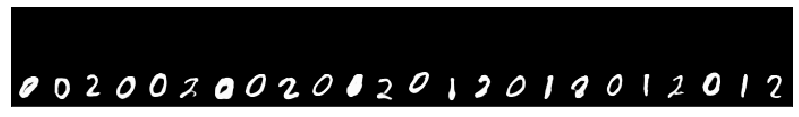

In [29]:
hidden_width = CONFIG.hidden_width
hidden_height = CONFIG.hidden_height
seq_len = hidden_width * hidden_height
embedding_dim = CONFIG.vocab_size
batch_size = 8

samples = torch.zeros(seq_len + 1, batch_size, embedding_dim).to(CONFIG.DEVICE)

sample_labels = torch.LongTensor([
    [0,0,2],
    [0,0,2],
    [0,0,2],
    [0,0,2],
    [0,1,2],
    [0,1,2],
    [0,1,2],
    [0,1,2]
]).to(CONFIG.DEVICE)

sample_noise = torch.randn(1, batch_size, CONFIG.vocab_size, device=CONFIG.DEVICE)

with torch.no_grad():
    for i in range(seq_len):
        out, cross_attn_maps = G(samples[:-1,:,:], sample_labels, sample_noise)
        
        z = ng_quantize(out, dim=-1)
        one_hot_sample = z[i,:,:]

        samples[i+1, :, :] = one_hot_sample

latent_x = samples[1:, :, :].view(hidden_height, hidden_width, batch_size, embedding_dim).permute(2, 3, 0, 1)

with torch.no_grad():
    gen_img = dvae.decode(latent_x)

img_grid = make_grid(gen_img.detach().cpu())
show(img_grid, figsize=(14, 8))

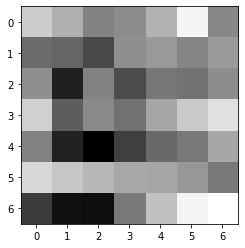

In [69]:
block_map = cross_attn_maps[-1]
token_block_map = block_map[12, :, 1].view(hidden_height, hidden_width)

pltheatmap = token_block_map.detach().cpu().numpy()

plt.imshow(pltheatmap, cmap='binary')
plt.show()